In [1]:
# Script for training a denoiser on KappaTNG
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'

from absl import app
from absl import flags

import tensorflow as tf
import tensorflow_datasets as tfds

import jax.numpy as jnp

from jax_lensing.inversion import ks93, ks93inv
from jax_lensing.utils import load_dataset

from astropy.io import fits

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
dataset = "kappatng"
batch_size = 32
map_size = 360
train_split = "80%"
noise_dist_std = 0.2

In [4]:
# Let's prepare some test data
def load_dataset():
    # test  set
    def pre_process(im):
        x = tf.image.random_crop(tf.expand_dims(im['map'],-1), [map_size,map_size,1])
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_flip_up_down(x)
        # Sample random Gaussian noise
        u = tf.random.normal(tf.shape(x))
        # Sample standard deviation of noise corruption
        s = noise_dist_std * tf.random.normal((1, 1, 1))
        # Create noisy image
        y = x + s * u
        return {'x':x, 'y':y, 'u':u,'s':s}
    ds = tfds.load('kappatng', split='train[-20%:]', shuffle_files=False)
    ds = ds.map(pre_process)
    return iter(tfds.as_numpy(ds))

In [5]:
test_set = load_dataset()

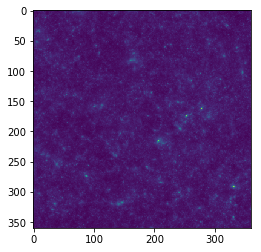

In [21]:
# Instantiate dataset and sample map
ref_map = next(test_set)['x']
ref_map.shape
imshow(ref_map[...,0])

In [30]:
mask = fits.getdata('../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits').astype('float32')

In [31]:
# We turn it into shear
e1, e2 = ks93inv(ref_map[...,0], jnp.zeros_like(ref_map[...,0]))
# And we extract a patch that put the big cluster right at the edge

k = ref_map[...,0]

(-0.5, 359.5, 359.5, -0.5)

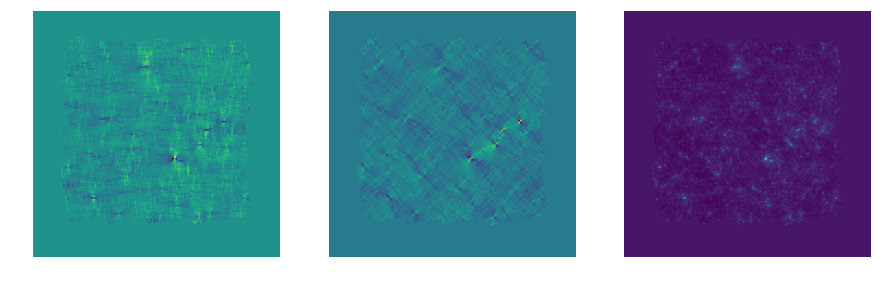

In [32]:
figure(figsize=[15,5])
subplot(131)
imshow(e1*mask)
axis('off')

subplot(132)
imshow(e2*mask)
axis('off')

subplot(133)
imshow(k*mask)
axis('off')

**Compare with True COSMOS shear noise**

0.14842282


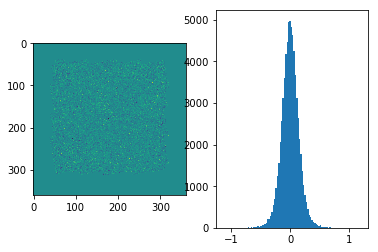

In [33]:
cosmos_e1 = fits.getdata('../data/COSMOS/cosmos_full_e1_0.29arcmin360.fits').astype('float32')
subplot(121)
imshow(cosmos_e1)
subplot(122)
m = cosmos_e1 == 0
hist(cosmos_e1[~m], 100);
print(jnp.std(cosmos_e1[~m]))

In [34]:
sigma_noise = 0.148 # We have a noise of 0.148

In [35]:
# And, last but not least, we can also include reduced shear
g1 = e1 / (1 - k)
g2 = e2 / (1 - k)

0.14926268


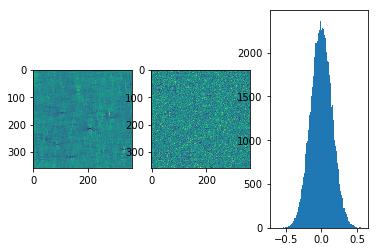

In [36]:
subplot(131)
imshow(e1)
subplot(132)
imshow(g1 + sigma_noise*randn(map_size,map_size))
subplot(133)
mock_cosmos_e1 = mask*(g1 + sigma_noise*randn(map_size,map_size))
m = mock_cosmos_e1 == 0
hist(mock_cosmos_e1[~m], 100);
print(jnp.std(mock_cosmos_e1[~m]))

In [37]:
# We can save for testing this map with added noise
fits.writeto('../data/ktng/ktng_cosmos_kappa{}.fits'.format(map_size),k)
fits.writeto('../data/ktng/ktng_cosmos_e{}.fits'.format(map_size),
              np.stack([mask*(g1 + sigma_noise*randn(map_size,map_size)),
                        mask*(g2 + sigma_noise*randn(map_size,map_size))],axis=-1))

In [ ]:
1+1